## Sistema de Recuperacion de Informaci on basado en Imagenes

### Adquisicion de Datos

In [1]:
import tensorflow as tf
from keras import layers, models
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
import itertools

c:\Users\usuario\Fer-Pc\Escritorio\EPN\2024-A\SEPTIMO_SEMESTRE\RECUPERACION_DE_INFORMACION\ir24a\venv3.8\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
(train_dataset, test_dataset), dataset_info = tfds.load(
    name='caltech101:3.0.2',
    split=['train[:80%]', 'test[20%:]'],
    with_info=True,
    as_supervised=True,
    data_dir='C:\\Users\\usuario\\Fer-Pc\\Escritorio\\EPN\\2024-A\\SEPTIMO_SEMESTRE\\RECUPERACION_DE_INFORMACION\\ir24a\\week14\\data',
    download=True,
)

num_classes = dataset_info.features['label'].num_classes

### Preprocesamiento

In [3]:
# Suponiendo que preprocess_image ya está definida para redimensionar y normalizar la imagen
def preprocess_image(image):
    image = tf.image.resize(image, [224, 224])
    image = image / 255.0  # Normalización (opcional)
    return image

In [4]:
def preprocess_dataset(dataset):
    return dataset.map(lambda x, y: (preprocess_image(x), y))

In [5]:
# Aplicar el preprocesamiento al conjunto de datos de entrenamiento y prueba
train_dataset = preprocess_dataset(train_dataset)
test_dataset = preprocess_dataset(test_dataset)


In [6]:
train_dataset = train_dataset.batch(32)
test_dataset = test_dataset.batch(32)

### Extraccion de Caracteristicas

In [7]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model

# Cargar el modelo VGG16 preentrenado
base_model = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Crear un nuevo modelo que produzca los mapas de características
model = tf.keras.Model(inputs=base_model.input, outputs=base_model.layers[-1].output)

In [8]:
def extract_features(dataset):
    features = []
    labels = []
    for images, lbls in dataset:
        feature_maps = model.predict(images)
        features.append(feature_maps)
        labels.append(lbls.numpy())
    features = np.concatenate(features, axis=0)
    labels = np.concatenate(labels, axis=0)
    return features, labels

In [9]:
# Ahora puedes extraer características de los conjuntos de datos
train_features, train_labels = extract_features(train_dataset)
test_features, test_labels = extract_features(test_dataset)

1/1 [==============================] - 2s 2s/step


### Indexacion

In [10]:
# Aplanar las características
train_features_flat = train_features.reshape(train_features.shape[0], -1)
test_features_flat = test_features.reshape(test_features.shape[0], -1)

In [11]:
from sklearn.neighbors import NearestNeighbors
import numpy as np

In [12]:
# Crear el índice de k-NN con las características extraídas
knn = NearestNeighbors(n_neighbors=5, algorithm='auto').fit(train_features_flat)

In [13]:
# Función para buscar imágenes similares
def find_similar_images(query_features, knn_index, k=5):
    distances, indices = knn_index.kneighbors(query_features, n_neighbors=k)
    return indices, distances

In [14]:
# Función para mostrar imágenes
def show_images(images, titles=None):
    plt.figure(figsize=(15, 5))
    for i, image in enumerate(images):
        plt.subplot(1, len(images), i + 1)
        plt.imshow(image)
        plt.axis('off')
        if titles is not None:
            plt.title(titles[i])
    plt.show()

# Función para obtener una imagen del dataset
def get_image_from_dataset(dataset, index):
    current_index = 0
    for batch_images, batch_labels in dataset:
        for i in range(len(batch_images)):
            if current_index == index:
                return batch_images[i].numpy(), batch_labels[i].numpy()
            current_index += 1
    return None, None

# Función para buscar y mostrar imágenes similares
def search_and_display(query_image_index, test_dataset, train_dataset, knn_index, k=5):
    query_image, query_label = get_image_from_dataset(test_dataset, query_image_index)
    if query_image is None:
        print(f"Query image with index {query_image_index} not found.")
        return
    # Mostrar la imagen de consulta
    plt.imshow(query_image)
    plt.title("Query Image")
    plt.axis('off')
    plt.show()
    
    query_features = test_features_flat[query_image_index].reshape(1, -1)
    indices, distances = find_similar_images(query_features, knn_index, k)
    
    similar_images = []
    for idx in indices[0]:
        similar_image, _ = get_image_from_dataset(train_dataset, idx)
        if similar_image is not None:
            similar_images.append(similar_image)
    
    show_images([query_image] + similar_images, titles=["Query"] + [f"Similar {i+1}" for i in range(len(similar_images))])

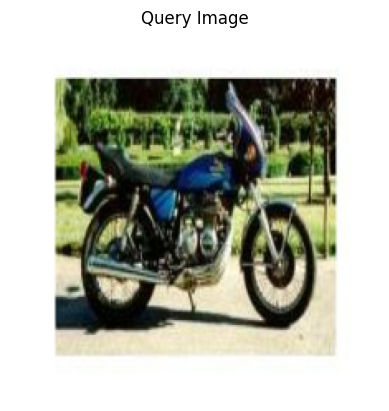

c:\Users\usuario\Fer-Pc\Escritorio\EPN\2024-A\SEPTIMO_SEMESTRE\RECUPERACION_DE_INFORMACION\ir24a\venv3.8\lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\usuario\Fer-Pc\Escritorio\EPN\2024-A\SEPTIMO_SEMESTRE\RECUPERACION_DE_INFORMACION\ir24a\venv3.8\lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


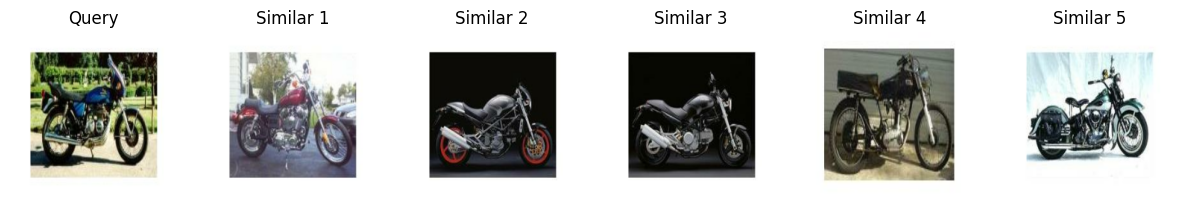

In [15]:
# Ejemplo de uso: buscar imágenes similares a la imagen con índice 0 en el conjunto de prueba
search_and_display(0, test_dataset, train_dataset, knn)